In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import mne
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import copy

In [2]:
#Takes string with file path as argument (eg. "/files/file.edf.seizure)
#Returns array on the format [1st seizure start time, 1st seizure start time in samples, 1st seizure end time, 1st seizure end time in samples, ...... , nth seizure start time, nth seizure start time in samples, nth seizure end time, nth seizure end time in samples]

def openSeizure(file):
    data = []
    with open(file,"rb") as f:
        buf = []
        byte = f.read(1)
        i = 0
        while byte:
            byte = f.read(1)
            if len(buf)<4:
                buf.append(byte)
            else:
                buf = buf[1:] #throw away oldest byte
                buf.append(byte) #append new byte to end.
            i = i+1
            #print(byte)

            if buf ==[b'\x01', b'\x00',b'\x00',b'\xec']: #0x010000ec appears to be a control sequence of some sort, signifying beginning of seizure data
                while byte:
                    byte = f.read(1) #next byte should be msb of seizure offset in seconds
                    if byte == b'':
                        continue #if byte is empty we've reached end of file
                    data.append(byte)
                    f.seek(2,1) #skip over next 2 bytes, they seem unimportant
                    byte = f.read(1)#this byte should be lsb of seizure offset in seconds
                    data.append(byte)
                    f.seek(7,1)#skip over next 7 bytes, again they seem unimportant
                    byte = f.read(1)#this should be the length of seizure in seconds
                    data.append(byte)
                    f.seek(4,1)#skip over next 4 bytes, if there are more seizures, looping should handle them.
                continue # once we've finished reading the seizures, we're finished with the file

        #print(data)
    legible_data = []
    i = 0
    currentTimePointer = 0 #the time points seem to be in offsets from last event for some godforsaken reason so this is for keeping current time
    while i<len(data):
        startTimeSec = data[i] + data[i+1]
        lengthSecInt = int.from_bytes(data[i+2], "big")
        startTimeSecInt = int.from_bytes(startTimeSec, "big") #get ints from parsed bytes
        currentTimePointer = currentTimePointer + startTimeSecInt #increment current time by start seizure event offset
        legible_data.append(currentTimePointer) #add current time to array
        legible_data.append(currentTimePointer*256) #convert seconds to samples
        currentTimePointer = currentTimePointer + lengthSecInt #increment current time by end of the seizure event offset
        legible_data.append(currentTimePointer) #add current time to array
        legible_data.append(currentTimePointer*256) #convert seconds to samples
        i = i+3 #weve got 3 datapoints per seizure so just move to the next one
    print(file)#print the file path for clarity
    print(legible_data)#print the datapoints for clarity
    return legible_data
#some test code, disregard
#openSeizure("chb04_05.edf.seizures")
#openSeizure("chb04_08.edf.seizures")
#openSeizure("chb04_28.edf.seizures")
#openSeizure("chb17b_63.edf.seizures")

In [3]:
file = "data\\chb01\\chb01_03.edf"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names

Extracting EDF parameters from C:\Users\Fabian\PycharmProjects\EpilepsyProject\data\chb01\chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\Fabian\AppData\Local\Temp\ipykernel_10860\232189870.py:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)


In [4]:
print(raw_data[0].size)
print(raw_data.size/raw_data[0].size)
for i in range(0,20):
    print(raw_data[0][i])

921600
23.0
-1.7777777777777777e-05
1.9536019536019466e-07
1.9536019536019466e-07
5.860805860805853e-07
1.9536019536019466e-07
-1.3675213675213682e-06
-2.14896214896215e-06
5.860805860805853e-07
2.9304029304029295e-06
-5.860805860805868e-07
-6.837606837606838e-06
-1.6214896214896215e-05
-2.3247863247863247e-05
-2.2857142857142858e-05
-1.973137973137973e-05
-1.855921855921856e-05
-2.0512820512820515e-05
-2.2075702075702074e-05
-1.973137973137973e-05
-1.8168498168498165e-05


In [5]:
openSeizure("data/chb01/chb01_04.edf.seizures")

data/chb01/chb01_04.edf.seizures
[1467, 375552, 1494, 382464]


[1467, 375552, 1494, 382464]

data/chb01/chb01_03.edf.seizures
[2996, 766976, 3036, 777216]


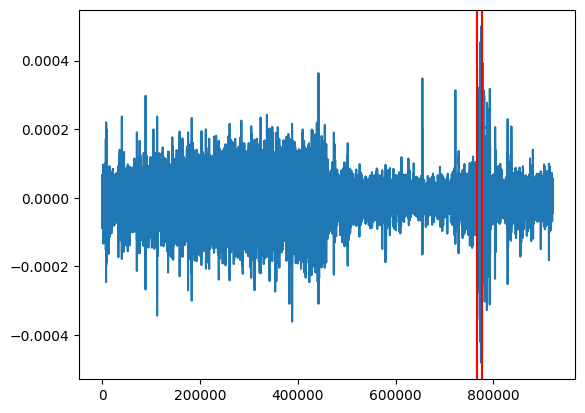

In [10]:
time = range(0,raw_data[0].size)
plt.plot(time,raw_data[0])
xcoords = openSeizure("data/chb01/chb01_03.edf.seizures")
coords_count = 0
for xc in xcoords:
    if coords_count % 2 == 1:
        plt.axvline(x=xc, color='r')
    coords_count = coords_count + 1

In [7]:
def LabelData(seizurecoords, datasize, labelsize):
    labels = np.zeros(int(labelsize))
    scale = datasize/labelsize
    if len(seizurecoords) >= 4:
        for i in range(0,labels.size):
            if (i*scale>=seizurecoords[0] and i*scale<=seizurecoords[1]) or (i*scale>=seizurecoords[2] and i*scale<=seizurecoords[3]):
                labels[i]=1 #seizure = 1, otherwise = 0
    return labels

In [8]:
def MakeDataWindows(data, channels, xsize, out_data):
    s = (int(channels), int(xsize))
    scaledata = 1000
    pic = np.zeros(s)
    #print(pic[22][22])
    print(f'Running for {int(data.size/xsize/channels)} iterations')
    for i in range(int(data.size/xsize/channels)):
        for j in range(int(channels)):
            for k in range(int(xsize)):
                pic[j][k] = float(data[j][int(i * xsize + k)]) * 1000
        out_data.append(pic)
        print(
            f'\rLoop {i}',
            end=''
        )
    print(f'\nLoop Complete\n')

In [9]:
out_data = []
MakeDataWindows(raw_data, raw_data.size/raw_data[0].size, raw_data.size/raw_data[0].size, out_data)
print(f'All Done!')

Running for 40069 iterations
Loop 40068
Loop Complete

All Done!


In [10]:
seizurecoords = openSeizure("data/chb01/chb01_04.edf.seizures")
labels = LabelData(seizurecoords,raw_data[0].size,raw_data[0].size/(raw_data.size/raw_data[0].size))
#print(
#    f'\rEpoch {epoch+1} [{batch_nr+1}/{len(train_loader)}] - Loss: {loss}',
#    end=''
#)

data/chb01/chb01_04.edf.seizures
[1467, 375552, 1494, 382464]


In [11]:
print(labels[int(seizurecoords[3]/23)])
print(labels[int(seizurecoords[3]/23)+1])

1.0
0.0


In [3]:
#download custom dataset
pic = np.zeros((23, 256))
out_data = []
labels = []
done_counter = 0
scalefactor = 1/32768

#opening the text file
with open('data/chb01/chb01.txt','r') as file:
    # reading each line
    for line in file:
        a = 0
        label = -1
        row = 0
        b = 0
        pic = np.zeros((23, 256))
        # reading each word
        #sosda = np.array(line.split)
        #print(sosda.size)
        for word in line.split():
            if a == 0 and row == 0 and label == -1:
                label = int(word)
                a = a - 1
            elif row < 256:
                #b = b + 1
                pic[a][row] = scalefactor * int(word)
                if a >= 22:
                    a = 0
                    row = row + 1
            a = a + 1
        out_data.append(pic)
        labels.append(label)
        done_counter = done_counter + 1
        if done_counter % 100 == 0:
            print(
                f'\r{done_counter} done ({b})',
                end=''
            )
        #'data/chb01/chb01.txt' 43200 size, should take roughly 2 minutes to load
        #'data/chb01/chb01_no_15_16.txt' 28800 size, should take roughly 2 minutes to load
        #'data/chb03/chb03.txt' 14400 size, should take a little less than a minute to load

43200 done (0)

In [44]:
#remove all seizures
done_counter = 0
for q in range(len(labels)):
    s = len(labels) - q - 1
    if labels[s] == 2:
        del labels[s]
        del out_data[s]
    if q % 100 == 0:
        print(
            f'\r{q} done',
            end=''
        )

28700 done

In [4]:
#0
print(len(out_data[0]))
print(int(out_data[0].size/len(out_data[0])))
print(out_data[0])
#1
print(len(out_data[1]))
print(int(out_data[1].size/len(out_data[1])))
print(out_data[1])
#these should be different from eachother

23
256
[[-0.65628052  0.          0.         ...  0.          0.
   0.        ]
 [-0.23440552  0.          0.203125   ...  0.1484375  -0.37503052
   0.140625  ]
 [-0.53128052 -0.02346802  0.         ...  0.296875    0.3359375
  -0.20315552]
 ...
 [ 0.2578125   0.6171875   0.5234375  ...  0.46875    -0.47659302
  -0.39846802]
 [-0.37503052 -0.22659302  0.5703125  ... -0.13284302  0.8359375
   0.375     ]
 [ 0.15625    -0.38284302 -0.25784302 ...  0.1015625  -0.20315552
  -0.65625   ]]
23
256
[[-0.21099854  0.          0.         ...  0.          0.
   0.        ]
 [ 0.03125     0.         -0.10159302 ... -0.19534302  0.484375
   0.1015625 ]
 [ 0.3984375   0.          0.         ...  0.0546875  -0.38284302
   0.5078125 ]
 ...
 [ 0.15625    -0.55471802 -0.15628052 ...  0.4609375   0.359375
  -0.12503052]
 [ 0.74215698 -0.01565552 -0.73440552 ...  0.328125    0.3515625
   0.578125  ]
 [-0.06253052  0.55465698 -0.18753052 ...  0.109375   -0.02346802
   0.3203125 ]]


In [10]:
batch_size = 1
tensor_data = torch.Tensor(np.array(out_data))
tensor_labels = torch.Tensor(np.array(labels))
dataset = TensorDataset(tensor_data,tensor_labels)
dataset_size = len(dataset)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = int(dataset_size - train_size - val_size)
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 4)     #channels in, channels out, kernel size
        self.pool = nn.MaxPool2d(2, 2)      #kernel size, stride (?)
        self.conv2 = nn.Conv2d(4, 5, 4)
        self.fc1 = nn.Linear((183)*5, 128)#self.fc1 = nn.Linear((256-4-4)*5, 128), med 3 kernel size
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))#F.leaky_relu
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = torch.flatten(x)
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [12]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    best_model = -1
    best_loss = float('inf')
    count = 0

    for epoch in range(num_epochs):
        for batch_nr, (data, labels) in enumerate(train_loader):

            with torch.set_grad_enabled(True):
            #if 1:

                labels = torch.nn.functional.one_hot(labels.to(torch.int64), 3)#np.transpose(torch.nn.functional.one_hot(labels.to(torch.int64), 3))
                labels = labels[0].float()

                prediction = model.forward(data)

                #print(labels.size());
                #print(labels);
                #print(prediction.size());
                #print(prediction);

                loss = criterion(prediction, labels)

                loss.backward()

                optimizer.step()

                optimizer.zero_grad()

                print(
                    f'\rEpoch {epoch+1} [{batch_nr+1}/{len(train_loader)}] - Loss: {loss}',
                    end=''
                )


        total_loss = 0
        for batch_nr, (data, labels) in enumerate(val_loader):
            labels = torch.nn.functional.one_hot(labels.to(torch.int64), 3)
            labels = labels[0].float()

            prediction = model.forward(data)

            loss = criterion(prediction, labels)

            total_loss += loss

        if total_loss < best_loss:
            best_loss = total_loss
            best_model = copy.deepcopy(model)
            print(" New best model! - Loss: "+str(float(best_loss)))
        #else:
            #model = copy.deepcopy(best_model)


    return best_model

In [13]:
def test_model(model, test_loader):
    correct = 0
    total = 0
    count = 0
    c = np.zeros(3)
    d = np.zeros([3,3])

    for batch_nr, (data, labels) in enumerate(test_loader):
        prediction = model.forward(data.float())

        if prediction.dim() == 1:
            prediction = torch.argmax(prediction).float()
            #print(
            #    f'\rEpoch {epoch+1} [{batch_nr+1}/{len(train_loader)}] - Loss: {loss}',
            #    end=''
            #)
            correct += int(prediction==labels)
            total += 1
            #print(int(prediction), int(labels))
            c[prediction.to(torch.int32)] += 1
            d[prediction.to(torch.int32)][int(labels)] += 1
        else:
            prediction = torch.argmax(prediction, dim=1).float()
            correct += int(((prediction - labels) == 0).sum())
            total += len(prediction)
            #print(int(prediction), int(labels))
    print(f'{c[0]} 0s [{d[0][0]}, {d[0][1]}, {d[0][2]}]\n{c[1]} 1s [{d[1][0]}, {d[1][1]}, {d[1][2]}]\n{c[2]} 2s [{d[2][0]}, {d[2][1]}, {d[2][2]}]')
    return 100 * correct / total

In [14]:
def test_random(model, test_loader):
    cnt=0
    for batch_nr, (data, labels) in enumerate(test_loader):
        cnt = cnt + 1
    cnt2=0
    rnd = int(np.random.rand(1,1)*cnt)
    for batch_nr, (data, labels) in enumerate(test_loader):

        if cnt2 == rnd:
            prediction = model.forward(data)
            print(data)
            print(str(prediction) + " " + str(rnd))
        cnt2 = cnt2 + 1

In [15]:
#Network
model = Net()

#Device
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model = model.to(device)

#Loss function
criterion = nn.MSELoss()#nn.CrossEntropyLoss()

#Optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.0003)#lr=0.001 in 4 epochs got ~76% overall accuracy, 0.0005 in 2 got 74.6

In [16]:
#about 1-2 min per epoch, more with a big dataset, more with a slower computer
trained_model = 0
trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, 2)

Epoch 1 [25920/25920] - Loss: 0.25621500611305237338 New best model! - Loss: 1355.7235107421875
Epoch 2 [25920/25920] - Loss: 0.05359150841832161455 New best model! - Loss: 1333.21435546875


In [17]:
#trained_model = model #TESTING

tested_model = test_model(trained_model, train_loader)
print("model has " + str(tested_model) + "% accuracy on training set")

6005.0 0s [5786.0, 192.0, 27.0]
7429.0 1s [1192.0, 4413.0, 1824.0]
12486.0 2s [1706.0, 3907.0, 6873.0]
model has 65.8641975308642% accuracy on training set


In [18]:
tested_model = test_model(trained_model, test_loader)
print("model has " + str(tested_model) + "% accuracy on test set")

1969.0 0s [1883.0, 82.0, 4.0]
2565.0 1s [414.0, 1484.0, 667.0]
4106.0 2s [560.0, 1419.0, 2127.0]
model has 63.58796296296296% accuracy on test set


In [56]:
#retrain
model = copy.deepcopy(trained_model)
trained_model = 0
trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, 1)

Epoch 1 [10440/10440] - Loss: 0.3503731191158294744New best model!


In [16]:
test_random(trained_model, train_loader)
test_random(trained_model, val_loader)
test_random(trained_model, test_loader)
test_random(trained_model, train_loader)
test_random(trained_model, train_loader)

tensor([[[ 0.4219,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.4453,  0.3594, -0.2813,  ...,  0.1328, -0.2266, -0.6719],
         [-0.6250, -0.4297,  0.2266,  ...,  0.0078,  0.2500, -0.4141],
         ...,
         [-0.3438, -0.1250,  0.2266,  ...,  0.1250,  0.1719, -0.4141],
         [-0.1485, -0.3516, -0.1563,  ..., -0.5782,  0.4219,  0.2344],
         [ 0.3828, -0.1094, -0.5234,  ...,  0.4062, -0.5157,  0.6406]]])
tensor([0.5733, 0.3002, 0.0922], grad_fn=<AddBackward0>) 11316
tensor([[[-0.0781,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.6250, -0.1797,  0.5078,  ..., -0.1485, -0.8750,  0.2344],
         [ 0.3359, -0.5000, -0.1484,  ...,  0.8203, -0.3047, -0.8203],
         ...,
         [-0.2813, -0.5469,  0.3203,  ..., -0.0547, -0.3828, -0.0938],
         [-0.8985, -0.4453, -0.6641,  ...,  0.9062,  0.0938, -0.2969],
         [ 0.3672, -0.5938, -0.4375,  ..., -0.1797,  0.7344,  0.0078]]])
tensor([0.0815, 0.5420, 0.2877], grad_fn=<AddBackward

In [52]:
#export?
dummy_input = torch.randn(1, 23, 256)
print(dummy_input.size())
torch.onnx.export(trained_model, dummy_input, "out_model.onnx", verbose=False)

torch.Size([1, 23, 256])


In [19]:
#before running this, download another dataset
batch_size = 1
tensor_data = torch.Tensor(np.array(out_data))
tensor_labels = torch.Tensor(np.array(labels))
controlset = TensorDataset(tensor_data,tensor_labels)
control_loader = DataLoader(controlset, batch_size=batch_size, shuffle=True)

In [29]:
tested_model = test_model(trained_model, control_loader)
print("model has " + str(tested_model) + "% accuracy on control set")

13793.0 0s [4767.0, 4581.0, 4445.0]
362.0 1s [6.0, 149.0, 207.0]
245.0 2s [27.0, 70.0, 148.0]
model has 35.166666666666664% accuracy on control set


In [48]:
#download custom datafile
pic = np.zeros((23, 256))
my_data = []
my_labels = []
done_counter = 0
scalefactor = 1/32768

#opening the text file
with open('data/chb01/data_chb03_06.txt','r') as file:
    # reading each line
    for line in file:
        a = 0
        label = -1
        row = 0
        b = 0
        pic = np.zeros((23, 256))
        # reading each word
        #sosda = np.array(line.split)
        #print(sosda.size)
        for word in line.split():
            if a == 0 and row == 0 and label == -1:
                label = int(word)
                a = a - 1
            elif row < 256:
                #b = b + 1
                pic[a][row] = scalefactor * int(word)
                if a >= 22:
                    a = 0
                    row = row + 1
            a = a + 1
        my_data.append(pic)
        my_labels.append(label)
        done_counter = done_counter + 1
        if done_counter % 100 == 0:
            print(
                f'\r{done_counter} done ({b})',
                end=''
            )
        ##3599 size

3500 done (0)

In [49]:
tensor_data = torch.Tensor(np.array(my_data))
tensor_labels = torch.Tensor(np.array(my_labels))
realset = TensorDataset(tensor_data,tensor_labels)
real_loader = DataLoader(realset, batch_size=batch_size, shuffle=False)

In [50]:
alarm_data = []
sum_data = []
average_over = 30
average = np.zeros(average_over)
a = 0
for batch_nr, (data, labels) in enumerate(real_loader):
        a=a+1
        prediction = trained_model.forward(data.float())
        prediction = prediction[1] - prediction[0]
        #if prediction == 2:
        #    prediction=0.5
        alarm_data.append(prediction)
        average[a%average_over]=prediction
        sum_data.append(np.sum(average))


FileNotFoundError: [Errno 2] No such file or directory: 'data/chb01/chb03_06.edf.seizures'

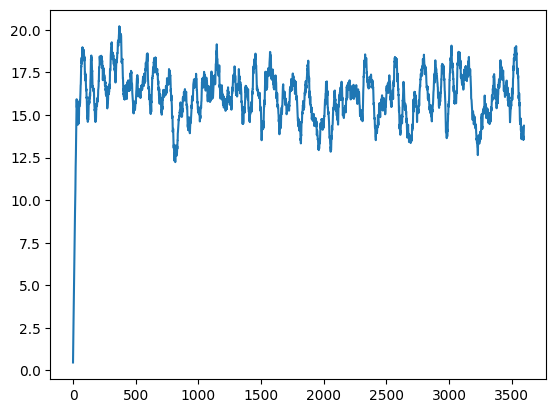

In [51]:

time = range(0,len(sum_data))
plt.plot(time,sum_data)
xcoords = openSeizure("data/chb01/chb03_06.edf.seizures")
coords_count = 0
for xc in xcoords:
    xc = xc / 256
    if coords_count % 2 == 1:
        plt.axvline(x=xc, color='r')
    coords_count = coords_count + 1

In [51]:
tested_model = test_model(trained_model, real_loader)
print("model has " + str(tested_model) + "% accuracy on control set")

682.0 0s [640.0, 35.0, 7.0]
2309.0 1s [2031.0, 247.0, 31.0]
608.0 2s [587.0, 18.0, 3.0]
model has 24.729091414281744% accuracy on control set


In [ ]:
print(my_labels)